In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *

import dill as pickle

## Language modeling

### Data

The [large movie view dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB. The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

However, before we try to classify *sentiment*, we will simply try to create a *language model*; that is, a model that can predict the next word in a sentence. Why? Because our model first needs to understand the structure of English, before we can expect it to recognize positive vs negative sentiment.

So our plan of attack is the same as we used for Dogs v Cats: pretrain a model to do one thing (predict the next word), and fine tune it to do something else (classify sentiment).

Unfortunately, there are no good pretrained language models available to download, so we need to create our own. To follow along with this notebook, we suggest downloading the dataset from [this location](http://files.fast.ai/data/aclImdb.tgz) on files.fast.ai.

In [2]:
PATH='data/aclImdb/'

TRN_PATH = 'train/all/'
VAL_PATH = 'test/all/'
TRN = f'{PATH}{TRN_PATH}'
VAL = f'{PATH}{VAL_PATH}'

%ls {PATH}

imdbEr.txt  imdb.vocab.back  models/  README  test/  tmp/  train/


Let's look inside the training folder...

In [18]:
trn_files = !ls {TRN}
trn_files[:10]

['0_0.txt',
 '0_3.txt',
 '0_9.txt',
 '10000_0.txt',
 '10000_4.txt',
 '10000_8.txt',
 '1000_0.txt',
 '10001_0.txt',
 '10001_10.txt',
 '10001_4.txt']

In [19]:
len(trn_files)

2501

...and at an example review.

In [20]:
review = !cat {TRN}{trn_files[6]}
review[0]

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop-socky fung-ku, but what I got instead was a comedy. So, it wasn't quite was I was expecting, but I really liked it anyway! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them!! I was laughing my ass off. I mean, the cops were just so bad! And when I say bad, I mean The Shield Vic Macky bad. But unlike that show I was laughing when they shot people and smoked dope.<br /><br />Felissa Rose...man, oh man. What can you say about that hottie. She was great and put those other actresses to shame. She should work more often!!!!! I also really liked the fight scene outside of the building. That was done really well. Lots of fighting and people getting their heads banged up. FUN! Last, but not least Joe Estevez and William Smith were great as the...well, I wasn't sure what they were, but they seemed to be having fun and throwing out 

Sounds like I'd really enjoy *Zombiegeddon*...

Now we'll check how many words are in the dataset.

In [21]:
!find {TRN} -name '*.txt' | xargs cat | wc -w

570253


In [22]:
!find {VAL} -name '*.txt' | xargs cat | wc -w

563063


In [23]:
x = "_a -bite .kite $1."
spacy_tok(x)

['_', 'a', '-bite', '.kite', '$', '1', '.']

Before we can analyze text, we must first *tokenize* it. This refers to the process of splitting a sentence into an array of words (or more generally, into an array of *tokens*).

In [24]:
' '.join(spacy_tok(review[0]))

"I have to say when a name like Zombiegeddon and an atom bomb on the front cover I was expecting a flat out chop - socky fung - ku , but what I got instead was a comedy . So , it was n't quite was I was expecting , but I really liked it anyway ! The best scene ever was the main cop dude pulling those kids over and pulling a Bad Lieutenant on them ! ! I was laughing my ass off . I mean , the cops were just so bad ! And when I say bad , I mean The Shield Vic Macky bad . But unlike that show I was laughing when they shot people and smoked dope . \n\n Felissa Rose ... man , oh man . What can you say about that hottie . She was great and put those other actresses to shame . She should work more often ! ! ! ! ! I also really liked the fight scene outside of the building . That was done really well . Lots of fighting and people getting their heads banged up . FUN ! Last , but not least Joe Estevez and William Smith were great as the ... well , I was n't sure what they were , but they seemed t

We use Pytorch's [torchtext](https://github.com/pytorch/text) library to preprocess our data, telling it to use the wonderful [spacy](https://spacy.io/) library to handle tokenization.

First, we create a torchtext *field*, which describes how to preprocess a piece of text - in this case, we tell torchtext to make everything lowercase, and tokenize it with spacy.

In [25]:
TEXT = data.Field(lower=True, tokenize=spacy_tok)

fastai works closely with torchtext. We create a ModelData object for language modeling by taking advantage of `LanguageModelData`, passing it our torchtext field object, and the paths to our training, test, and validation sets. In this case, we don't have a separate test set, so we'll just use `VAL_PATH` for that too.

As well as the usual `bs` (batch size) parameter, we also not have `bptt`; this define how many words are processing at a time in each row of the mini-batch. More importantly, it defines how many 'layers' we will backprop through. Making this number higher will increase time and memory requirements, but will improve the model's ability to handle long sentences.

* `LanguageModelData.from_text_files` (`nlp.py`)
* ---> Creates `LanguageModelDataLoader` for train/val/test (`nlp.py`)
* ------------> `batchify` (creates batches), numericalize, `bptt` (?) (`nlp.py`)
* `LMD.get_model` --> `RNN_learner(get_language_model, opt_fn)`    (`nlp.py`)
* ------------> `get_language_model` : [`RNN_Encoder` + `LinearDecoder`]   (`lm_rnn.py`)
* --------------------------> `RNN_Encoder` is the holygrail. It is the core LSTM layers which does the text processing.
* --------------------------> (number of words) 757 -> encoded to 200 (embedding size) -> decoded back to 757
* --------------------------> save/load_encoder : saves/loads the RNN_Encoder only 

In [26]:
bs=64; bptt=70

In [27]:
FILES = dict(train=TRN_PATH, validation=VAL_PATH, test=VAL_PATH)
md = LanguageModelData.from_text_files(PATH, TEXT, **FILES, bs=bs, bptt=bptt, min_freq=10)

After building our `ModelData` object, it automatically fills the `TEXT` object with a very important attribute: `TEXT.vocab`. This is a *vocabulary*, which stores which words (or *tokens*) have been seen in the text, and how each word will be mapped to a unique integer id. We'll need to use this information again later, so we save it.

*(Technical note: python's standard `Pickle` library can't handle this correctly, so at the top of this notebook we used the `dill` library instead and imported it as `pickle`)*.

In [28]:
pickle.dump(TEXT, open(f'{PATH}models/TEXT.pkl','wb'))

Here are the: # batches; # unique tokens in the vocab; # tokens in the training set; # sentences

In [29]:
len(md.trn_dl), md.nt, len(md.trn_ds), len(md.trn_ds[0].text)

(148, 4669, 1, 670763)

This is the start of the mapping from integer IDs to unique tokens.

In [30]:
# 'itos': 'int-to-string'
TEXT.vocab.itos[:12]

['<unk>', '<pad>', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is', 'it', 'in']

In [31]:
# 'stoi': 'string to int'
TEXT.vocab.stoi['eye']

642

Note that in a `LanguageModelData` object there is only one item in each dataset: all the words of the text joined together.

In [34]:
md.trn_ds[0].text[:12]

['i',
 'would',
 'like',
 'to',
 'comment',
 'the',
 'series',
 'as',
 'a',
 'great',
 'effort',
 '.']

torchtext will handle turning this words into integer IDs for us automatically.

In [35]:
TEXT.numericalize([md.trn_ds[0].text[:12]])

Variable containing:
   12
   68
   48
    8
 1027
    2
  175
   20
    6
   87
  773
    3
[torch.cuda.LongTensor of size 12x1 (GPU 0)]

Our `LanguageModelData` object will create batches with 64 columns (that's our batch size), and varying sequence lengths of around 80 tokens (that's our `bptt` parameter - *backprop through time*).

Each batch also contains the exact same data as labels, but one word later in the text - since we're trying to always predict the next word. The labels are flattened into a 1d array.

In [36]:
next(iter(md.trn_dl))

(Variable containing:
    12   180  1155  ...      5   375    97
    68     4  2944  ...   1184    89   548
    48    23  2607  ...      0   795     4
        ...          ⋱          ...       
   132  1067   632  ...     17     2    27
    22   244    23  ...    843   908   869
     0  1217   783  ...     17     4   913
 [torch.cuda.LongTensor of size 70x64 (GPU 0)], Variable containing:
    68
     4
  2944
   ⋮  
   184
   427
     3
 [torch.cuda.LongTensor of size 4480 (GPU 0)])

### Train

We have a number of parameters to set - we'll learn more about these later, but you should find these values suitable for many problems.

In [37]:
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers

Researchers have found that large amounts of *momentum* (which we'll learn about later) don't work well with these kinds of *RNN* models, so we create a version of the *Adam* optimizer with less momentum than it's default of `0.9`.

In [38]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

fastai uses a variant of the state of the art [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182) developed by Stephen Merity. A key feature of this model is that it provides excellent regularization through [Dropout](https://en.wikipedia.org/wiki/Convolutional_neural_network#Dropout). There is no simple way known (yet!) to find the best values of the dropout parameters below - you just have to experiment...

However, the other parameters (`alpha`, `beta`, and `clip`) shouldn't generally need tuning.

In [39]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
               dropouti=0.05, dropout=0.05, wdrop=0.1, dropoute=0.02, dropouth=0.05)
learner.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learner.clip=0.3

As you can see below, I gradually tuned the language model in a few stages. I possibly could have trained it further (it wasn't yet overfitting), but I didn't have time to experiment more. Maybe you can see if you can train it to a better accuracy! (I used `lr_find` to find a good learning rate, but didn't save the output in this notebook. Feel free to try running it yourself now.)

In [40]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       5.84116  5.60647]                                



In [41]:
learner.save_encoder('adam1_enc')

In [42]:
learner.fit(3e-3, 4, wds=1e-6, cycle_len=10, cycle_save_name='adam3_10')

A Jupyter Widget

[ 0.       5.6524   5.37792]                                
[ 1.       5.21043  4.93219]                                
[ 2.       4.94123  4.73695]                                
[ 3.       4.76907  4.61881]                                
[ 4.       4.65518  4.54808]                                
[ 5.       4.55792  4.50235]                                
[ 6.       4.49253  4.47466]                                
[ 7.       4.44072  4.46004]                                
[ 8.       4.41298  4.45356]                                
[ 9.       4.40162  4.452  ]                                
[ 10.        4.48541   4.44884]                             
[ 11.        4.3903    4.41459]                             
[ 12.        4.29464   4.4017 ]                             
[ 13.        4.19817   4.39197]                            
[ 14.        4.12164   4.38062]                             
[ 15.        4.04335   4.38156]                             
[ 16.        3.95896   4.

In [43]:
learner.save_encoder('adam3_10_enc')

In [15]:
learner.fit(3e-3, 1, wds=1e-6, cycle_len=20, cycle_save_name='adam3_20')

A Jupyter Widget

[ 0.      4.2122  4.1803]                                     
[ 1.      4.4048  4.2924]                                     
[ 2.      4.4049  4.292 ]                                     
[ 3.      4.3769  4.2839]                                     
[ 4.      4.3734  4.2757]                                     
[ 5.      4.3558  4.2684]                                     
[ 6.      4.3471  4.2587]                                     
[ 7.      4.3372  4.2475]                                     
[ 8.      4.3426  4.2398]                                     
[ 9.      4.3155  4.2253]                                     
[ 10.       4.2975   4.2165]                                  
[ 11.       4.2747   4.2057]                                  
[ 12.       4.2725   4.1949]                                  
[ 13.       4.2533   4.1861]                                  
[ 14.       4.2281   4.1788]                                  
[ 15.       4.226    4.1729]                           

In [19]:
learner.load_cycle('adam3_20', 0)

In the sentiment analysis section, we'll just need half of the language model - the *encoder*, so we save that part.

In [16]:
learner.save_encoder('adam3_20_enc')

Language modeling accuracy is generally measured using the metric *perplexity*, which is simply `exp()` of the loss function we used.

In [17]:
math.exp(4.165)

64.3926824434624

### Test

We can play around with our language model a bit to check it seems to be working OK. First, let's create a short bit of text to 'prime' a set of predictions. We'll use our torchtext field to numericalize it so we can feed it to our language model.

* `TEXT.numericalize(spacy_tok('string'))`

In [62]:
m=learner.model
ss=""". So, it wasn't quite was I was expecting, but I really liked it anyway! The best"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

". So , it was n't quite was I was expecting , but I really liked it anyway ! The best"

We haven't yet added methods to make it easy to test a language model, so we'll need to manually go through the steps.

In [68]:
# Set batch size to 1
m[0].bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from model
res,*_ = m(t)
# Put the batch size back to what it was
m[0].bs=bs

Let's see what the top 10 predictions were for the next word after our short text:

In [20]:
nexts = torch.topk(res[-1], 10)[1]
[TEXT.vocab.itos[o] for o in to_np(nexts)]

['performance',
 'of',
 'friend',
 'actor',
 'thing',
 'scene',
 'character',
 'part',
 'line',
 'movie']

...and let's see if our model can generate a bit more text all by itself!

In [69]:
print(ss,"\n")
for i in range(50):
    n=res[-1].topk(2)[1]
    n = n[1] if n.data[0]==0 else n[0]
    print(TEXT.vocab.itos[n.data[0]], end=' ')
    res,*_ = m(n[0].unsqueeze(0))
print('...')

. So, it wasn't quite was I was expecting, but I really liked it anyway! The best 

performance was the one in the movie where he was a little too old for the part . i think he was a good actor , but he was n't that good . 

 the movie was a bit slow , but it was n't too bad . the acting ...


### Sentiment

We'll need to the saved vocab from the language model, since we need to ensure the same words map to the same IDs.

In [3]:
# If Just loading the models initialize variables 
PATH='data/aclImdb/'
bs=64; bptt=70
em_sz = 200  # size of each embedding vector
nh = 500     # number of hidden activations per layer
nl = 3       # number of layers
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [4]:
TEXT = pickle.load(open(f'{PATH}models/TEXT.pkl','rb'))

`sequential=False` tells torchtext that a text field should be tokenized (in this case, we just want to store the 'positive' or 'negative' single label).

`splits` is a torchtext method that creates train, test, and validation sets. The IMDB dataset is built into torchtext, so we can take advantage of that. Take a look at `lang_model-arxiv.ipynb` to see how to define your own fastai/torchtext datasets.

* `splits` is a list containing `examples`.
* `examples` is a list containing fields : `labels` , `text`
* its so specific to text, then mix of embedding and text how will that work?

In [5]:
IMDB_LABEL = data.Field(sequential=False)
splits = torchtext.datasets.IMDB.splits(TEXT, IMDB_LABEL, 'data/')
train_ds, val_ds = splits

In [6]:
ds = train_ds
print("Examples: ", len(ds.examples))
t = ds.examples[0]
print("Example 0: label='{}', text='{}'".format(t.label, ' '.join(t.text[:20])))
print("Text vocab from TEXT: ", ds.fields['text'].vocab.itos[:15])
#Label-vocab is not yet there
#print("Label vocab: ", ds.fields['label'].vocab.itos[:])

Examples:  25000
Example 0: label='pos', text='i remember watching this movie with my friends when we were 4 years old , but the weird thing is'
Text vocab from TEXT:  ['<unk>', '<pad>', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that']


In [7]:
ds = val_ds
print("Examples: ", len(ds.examples))
t = ds.examples[0]
print("Example 0: label='{}', text='{}'".format(t.label, ' '.join(t.text[:20])))
print("Text vocab from TEXT: ", ds.fields['text'].vocab.itos[:15])
#print("Label vocab: ", ds.fields['label'].vocab.itos[:])

Examples:  25000
Example 0: label='pos', text='a ham actor without a penny . who better than michael caine to play such a character ? he is'
Text vocab from TEXT:  ['<unk>', '<pad>', 'the', '.', ',', 'and', 'a', 'of', 'to', 'is', 'it', 'in', 'i', 'this', 'that']


In [ ]:
train_ds['']

In [53]:
s = 'i remember watching this movie with my friends when we were 4 years old , but'

fastai can create a ModelData object directly from torchtext splits.

In [8]:
md2 = TextData.from_splits(PATH, splits, bs)

In [10]:
print("Label vocab: ", train_ds.fields['label'].vocab.itos[:])
print("Label vocab: ", val_ds.fields['label'].vocab.itos[:])

Label vocab:  ['<unk>', 'neg', 'pos']
Label vocab:  ['<unk>', 'neg', 'pos']


##### md2 has text data converted into numbers. Contains text observations, and their label in chunks of batch-size. Similar sized texts are grouped together which means sequences are changed. 
##### How do we add other fields if sequences are altered? Is there any way we can keep track of indices? 

In [11]:
trn_dl_inst = next(iter(md2.trn_dl))

In [12]:
print("X={}, Y={}".format(trn_dl_inst[0], trn_dl_inst[1][:10]))

X=Variable containing:
    2     0     5  ...     15  1304     0
   91  1294    10  ...   2085     5    98
  362     4    16  ...      0     0    34
       ...          ⋱          ...       
    1     1     1  ...    387     0    64
    1     1     1  ...     15   161  1561
    1     1     1  ...      3   395     3
[torch.cuda.LongTensor of size 205x64 (GPU 0)]
, Y=Variable containing:
 1
 2
 2
 2
 1
 2
 1
 2
 1
 1
[torch.cuda.LongTensor of size 10 (GPU 0)]



In [13]:
df = pd.DataFrame(trn_dl_inst[0].data.cpu().numpy())

In [14]:
df = (df.apply(lambda x: x.apply(lambda y: TEXT.vocab.itos[y])))

In [15]:
pd.options.display.max_rows = 300
pd.options.display.max_columns = 50
df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204
0,the,first,half,hour,or,so,of,this,movie,i,liked,.,the,obvious,<unk>,romance,between,ingrid,bergman,and,<unk>,<unk>,was,cute,to,...,rules,of,the,game,",",but,<unk>,and,her,men,had,me,<unk>,the,<unk>,and,<unk>,of,the,original,film,.,<pad>,<pad>,<pad>
1,<unk>,speaking,",",this,is,a,beautiful,movie,--,the,cinematography,",",music,and,costumes,are,gorgeous,.,in,fact,",",this,movie,is,<unk>,...,the,writing,.,it,'s,too,bad,that,the,<unk>,<unk>,in,this,movie,is,the,story,by,the,great,<unk>,.,<pad>,<pad>,<pad>
2,and,it,'s,not,because,since,her,days,on,"""",<unk>,explains,it,all,"""",that,i,'ve,had,a,bit,of,a,<unk>,on,...,realize,how,great,it,was,.,i,only,wish,there,were,some,<unk>,episodes,that,we,could,all,enjoy,.,\n\n,10/10,<pad>,<pad>,<pad>
3,this,story,was,probably,one,of,the,most,powerful,i,have,ever,taken,in,.,john,<unk>,certainly,went,above,and,beyond,when,putting,together,...,",","""",knowledge,is,power,",",without,knowledge,",",you,can,not,see,your,power,.,"""",brilliant,",",just,brilliant,.,<pad>,<pad>,<pad>
4,this,movie,proves,that,you,ca,n't,judge,a,movie,by,the,awesome,<unk>,on,the,dvd,cover,.,it,also,goes,to,show,that,...,.,and,for,first,-,time,viewers,",",it,is,really,fun,making,<unk>,of,the,order,of,people,who,die,.,<pad>,<pad>,<pad>
5,"""",twelve,<unk>,"""",'s,got,all,the,elements,to,become,<unk>,<unk>,'s,masterpiece,.,an,outstanding,screenplay,",",a,<unk>,<unk>,",",clever,...,",","""",twelve,<unk>,"""",will,be,<unk>,at,its,true,value,:,one,of,the,<unk>,made,in,the,<unk>,.,<pad>,<pad>,<pad>
6,<unk>,always,present,<unk>,for,dramatic,films,since,",",in,fact,",",most,<unk>,are,in,themselves,dramatic,events,.,unfortunately,",",what,this,film,...,the,french,<unk>,of,the,<unk>,into,the,"""",<unk>,-,<unk>,"""",<unk>,of,a,"""",<unk>,<unk>,"""",world,.,<pad>,<pad>,<pad>
7,i,saw,this,film,back,at,the,<unk>,<unk>,<unk>,international,film,festival,and,of,the,14,films,i,saw,there,i,would,<unk>,this,...,well,-,<unk>,cast,.,i,would,highly,recommend,this,film,and,rate,it,a,<unk>,on,a,scale,of,10,.,<pad>,<pad>,<pad>
8,just,imagine,the,real,hitler,",",who,was,a,master,of,propaganda,and,speech,",",would,have,been,such,a,<unk>,<unk>,as,<unk>,portrayed,...,.,\n\n,this,film,is,a,<unk>,and,i,wonder,how,they,could,talk,an,actor,like,<unk>,into,this,<unk>,.,<pad>,<pad>,<pad>
9,<unk>,is,jane,parker,",",whose,long,-,lost,<unk>,father,(,richard,<unk>,",",in,the,worst,role,of,a,very,<unk>,career,),...,think,of,.,the,<unk>,movie,guide,comments,that,they,almost,had,to,think,of,a,rating,lower,than,bomb,.,),<pad>,<pad>,<pad>


In [16]:
m3 = md2.get_model(opt_fn, 1500, bptt, emb_sz=em_sz, n_hid=nh, n_layers=nl, 
           dropout=0.1, dropouti=0.4, wdrop=0.5, dropoute=0.05, dropouth=0.3)
m3.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
m3.load_encoder(f'adam3_10_enc')

In [17]:
m3.model[0] # our text encoder

MultiBatchRNN (
  (encoder): Embedding(4669, 200, padding_idx=1)
  (rnns): ModuleList (
    (0): WeightDrop (
      (module): LSTM(200, 500, dropout=0.3)
    )
    (1): WeightDrop (
      (module): LSTM(500, 500, dropout=0.3)
    )
    (2): WeightDrop (
      (module): LSTM(500, 200, dropout=0.3)
    )
  )
  (dropouti): LockedDropout (
  )
  (dropouth): LockedDropout (
  )
)

In [21]:
m3.load('sentiment')

Because we're fine-tuning a pretrained model, we'll use differential learning rates, and also increase the max gradient for clipping, to allow the SGDR to work better.

In [18]:
m3.clip=25.
lrs=np.array([1e-4,1e-3,1e-2])

In [19]:
m3.freeze_to(-1)
m3.fit(lrs/2, 1, metrics=[accuracy])
m3.unfreeze()
m3.fit(lrs, 1, metrics=[accuracy], cycle_len=1)

A Jupyter Widget

[ 0.       0.66451  0.62974  0.64699]                        



A Jupyter Widget

[ 0.       0.58128  0.51792  0.7486 ]                        



In [20]:
m3.save('sentiment')

In [22]:
m3.model.xs

[Variable containing:
    13    79    12  ...   1004    20     0
   225   104    91  ...      0   485    16
    37     3   218  ...     16    20     0
        ...          ⋱          ...       
    66     3     3  ...     16    40  1013
     1     1     1  ...     67    40   141
     1     1     1  ...     40    40     3
 [torch.cuda.LongTensor of size 158x64 (GPU 0)]]

In [23]:
xs = [next(iter(md2.trn_dl))[0]]
xs

[Variable containing:
    12    59    10  ...      0    12     0
  1235    26     9  ...    312   229   101
     8   203    33  ...    241    10     4
        ...          ⋱          ...       
     0    40     3  ...      7    23    16
     1     1     1  ...    282   263  4261
     1     1     1  ...      3     3     3
 [torch.cuda.LongTensor of size 133x64 (GPU 0)]]

In [24]:
y_enc = m3.model[0](*xs)

In [26]:
len(y_enc)

2

In [88]:
m3.model[1](y_enc)

(Variable containing:
 -13.6922   2.5672   0.9540
 -13.6871   1.6259   1.8039
 -13.1104   1.6213   1.6806
 -14.5811   1.5519   2.0766
 -13.1894   1.5313   1.9416
 -13.3056   1.5064   1.8315
 -13.5071   1.6012   1.8456
 -14.1012   1.9201   1.5858
 -13.7990   1.3385   2.1899
 -13.5468  -0.0475   3.5184
 -12.9346   2.0525   1.1413
 -15.6283   0.1373   3.9081
 -13.3056   0.8936   2.4240
 -12.6531   3.0742   0.0462
 -13.3078   0.9945   2.4889
 -13.1815   1.6544   1.7247
 -13.2239   2.1265   1.3998
 -14.3126   1.4527   2.0796
 -13.8516   1.6764   1.9431
 -13.8304   1.5974   1.9494
 -13.6277   0.9055   2.5780
 -13.9730   1.4802   2.0065
 -13.9577   2.1175   1.6505
 -12.8788   0.9762   2.3770
 -13.2979   2.0112   1.3623
 -13.7677   1.4316   2.0329
 -13.2278   1.9866   1.4395
 -13.8921   1.1148   2.4679
 -14.1709   2.5659   0.8287
 -14.0340   0.7376   2.8777
 -14.8619   2.0785   1.5864
 -13.2286   1.8440   1.6197
 -13.1418   1.2287   2.1833
 -14.9330   2.0329   2.1902
 -14.5169   1.6231   1.943

In [27]:
ss=""". So, it wasn't quite was I was expecting, but I really liked it anyway! The best"""
s = [spacy_tok(ss)]
t=TEXT.numericalize(s)
' '.join(s[0])

". So , it was n't quite was I was expecting , but I really liked it anyway ! The best"

In [28]:
m = m3.model
m.bs=1
# Turn off dropout
m.eval()
# Reset hidden state
m.reset()
# Get predictions from m
m(t)

(Variable containing:
 -7.6950  0.4576  0.1787
 [torch.cuda.FloatTensor of size 1x3 (GPU 0)], [Variable containing:
  ( 0 ,.,.) = 
   -1.5676e-06 -2.5272e-01  4.8355e-04  ...   2.9164e-05 -1.8841e-03  2.0163e-01
  
  ( 1 ,.,.) = 
   -4.9877e-07  6.8833e-03 -6.9230e-01  ...  -5.6914e-01 -3.5425e-04  1.6215e-04
  
  ( 2 ,.,.) = 
   -1.2973e-07  5.4320e-01 -6.1214e-03  ...   1.4954e-01 -6.2470e-02  3.8935e-03
  ... 
  
  (18 ,.,.) = 
   -1.3904e-02  9.5423e-01  9.6234e-02  ...   5.1930e-04  1.4966e-01  2.7567e-01
  
  (19 ,.,.) = 
   -2.0770e-05  4.4509e-01 -5.7142e-01  ...   2.1999e-01  2.2373e-03  2.9370e-05
  
  (20 ,.,.) = 
    3.1438e-01  8.8209e-01 -3.3581e-01  ...  -9.4881e-02 -5.6004e-01  1.3530e-02
  [torch.cuda.FloatTensor of size 21x1x500 (GPU 0)], Variable containing:
  ( 0 ,.,.) = 
   -3.5081e-03 -4.2745e-03  7.1957e-03  ...  -2.8149e-02 -3.7656e-01  1.0664e-02
  
  ( 1 ,.,.) = 
   -6.6094e-03 -3.9780e-04 -3.0985e-01  ...  -1.2564e-02 -7.7555e-02  1.4975e-03
  
  ( 2 ,.,.) = 

In [30]:
y_enc = m[0](t)
y_enc

In [40]:
m[1](y_enc)

Variable containing:
( 0 ,.,.) = 
  2.3620e-02 -8.8165e-02 -5.1913e-03  ...   1.1614e-01 -9.2435e-02  2.7302e-02

( 1 ,.,.) = 
  2.7449e-02 -1.4643e-01  3.0659e-02  ...  -4.4212e-02 -2.3564e-01 -5.5125e-02

( 2 ,.,.) = 
 -1.2625e-01 -1.8342e-01 -1.9299e-02  ...  -4.0641e-01 -7.2220e-02  7.9026e-03
... 

(18 ,.,.) = 
 -5.5195e-02 -2.6052e-01  2.5358e-02  ...   1.8380e-02 -1.5635e-01 -7.4289e-02

(19 ,.,.) = 
 -8.8853e-02 -2.4122e-01  5.4257e-03  ...  -9.0406e-02 -1.6489e-01 -1.5008e-02

(20 ,.,.) = 
 -4.9098e-02 -1.8901e-02  3.9104e-02  ...  -4.1859e-03 -5.3048e-03  2.3672e-01
[torch.cuda.FloatTensor of size 21x1x200 (GPU 0)]

****************** OUTPUT -1= Variable containing:

Columns 0 to 9 
-0.0491 -0.0189  0.0391  0.0175  0.0765  0.0034 -0.0157  0.0002 -0.0563  0.0338

Columns 10 to 19 
 0.5097  0.0737  0.0201  0.2172 -0.0005 -0.0002 -0.1004  0.2204 -0.0199  0.0071

Columns 20 to 29 
 0.3078  0.0992 -0.0245 -0.0414  0.0035 -0.0000  0.0142  0.1252 -0.0482  0.0005

Columns 30 to 39 
-

(Variable containing:
 -7.6950  0.4576  0.1787
 [torch.cuda.FloatTensor of size 1x3 (GPU 0)], [Variable containing:
  ( 0 ,.,.) = 
   -1.5676e-06 -2.5272e-01  4.8355e-04  ...   2.9164e-05 -1.8841e-03  2.0163e-01
  
  ( 1 ,.,.) = 
   -4.9877e-07  6.8833e-03 -6.9230e-01  ...  -5.6914e-01 -3.5425e-04  1.6215e-04
  
  ( 2 ,.,.) = 
   -1.2973e-07  5.4320e-01 -6.1214e-03  ...   1.4954e-01 -6.2470e-02  3.8935e-03
  ... 
  
  (18 ,.,.) = 
   -1.3904e-02  9.5423e-01  9.6234e-02  ...   5.1930e-04  1.4966e-01  2.7567e-01
  
  (19 ,.,.) = 
   -2.0770e-05  4.4509e-01 -5.7142e-01  ...   2.1999e-01  2.2373e-03  2.9370e-05
  
  (20 ,.,.) = 
    3.1438e-01  8.8209e-01 -3.3581e-01  ...  -9.4881e-02 -5.6004e-01  1.3530e-02
  [torch.cuda.FloatTensor of size 21x1x500 (GPU 0)], Variable containing:
  ( 0 ,.,.) = 
   -3.5081e-03 -4.2745e-03  7.1957e-03  ...  -2.8149e-02 -3.7656e-01  1.0664e-02
  
  ( 1 ,.,.) = 
   -6.6094e-03 -3.9780e-04 -3.0985e-01  ...  -1.2564e-02 -7.7555e-02  1.4975e-03
  
  ( 2 ,.,.) = 

In [59]:
m3.predict_with_targs()

(array([[ -8.62956,   1.83301,   0.79491],
        [ -7.85512,   1.45698,   0.75426],
        [ -7.84695,   0.96968,   0.96806],
        ..., 
        [-14.71136,   3.01164,   1.02937],
        [-13.88812,   2.21012,   1.8218 ],
        [-15.12319,   2.74319,   1.64404]], dtype=float32),
 array([1, 1, 1, ..., 2, 2, 2]))

In [81]:
x = ''
for j, v in enumerate(to_np(m[0].try1)):
    x = ''
    for i, k in enumerate(v):
        x  += str(i)+' '+TEXT.vocab.itos[k]+' '
    print(j, " ", x, "\n")


0   0 if 1 short 2 she 3 more 4 going 5 a 6 <unk> 7 entertainment 8 come 9 cars 10 that 11 , 12 , 13 against 14 scene 15 <unk> 16 there 17 to 18 one 19 film 20 to 21 . 22 film 23 <unk> 24 this 25 say 26 there 27 another 28 another 29 . 30 where 31 johnny 32 " 33 certainly 34 . 35 if 36 70s 37 has 38 to 39 <unk> 40 good 41 - 42 , 43 <unk> 44 about 45 's 46 more 47 man 48 <unk> 49 hitchcock 50 " 51 wall 52 80 53 masterpiece 54 samantha 55 happened 56 the 57 action 58 laugh 59 her 60 superb 61 film 62 in 63 but  

1   0 you 1 of 2 's 3 focused 4 to 5 cynical 6 . 7 is 8 from 9 . 10 . 11 and 12 <unk> 13 her 14 with 15 <unk> 16 's 17 see 18 of 19 with 20 accomplish 21 the 22 in 23 for 24 is 25 never 26 . 27 season 28 actress 29 the 30 <unk> 31 dies 32 north 33 recommended 34 it 35 the 36 learned 37 neither 38 be 39 after 40 vs 41 budget 42 that 43 western 44 <unk> 45 just 46 things 47 ever 48 for 49 's 50 why 51 , 52 's 53 , 54 's 55 . 56 plain 57 <unk> 58 , 59 dad 60 , 61 - 62 london 63 som

In [58]:
m3.fit(lrs, 7, metrics=[accuracy], cycle_len=2, cycle_save_name='imdb2')

A Jupyter Widget

 11%|█▏        | 44/390 [00:12<01:35,  3.61it/s, loss=0.591]

KeyboardInterrupt: 

In [78]:
m3.load_cycle('imdb2', 4)

In [84]:
accuracy(*m3.predict_with_targs())

0.61650641025641029

In [52]:
m = m3.model

A recent paper from Bradbury et al, [Learned in translation: contextualized word vectors](https://einstein.ai/research/learned-in-translation-contextualized-word-vectors), has a handy summary of the latest academic research in solving this IMDB sentiment analysis problem. Many of the latest algorithms shown are tuned for this specific problem.

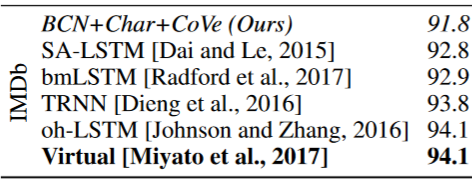

As you see, we just got a new state of the art result in sentiment analysis, decreasing the error from 5.9% to 5.5%! You should be able to get similarly world-class results on other NLP classification problems using the same basic steps.

There are many opportunities to further improve this, although we won't be able to get to them until part 2 of this course...

### End